In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive
FOLDERNAME = 'Colab Notebooks/one_object/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


# Import modules
You will need to move the following files from the repo into your floder:

* models/transformer_model.py
* utils/TransformerDataset.py
* 20120123S11_EEGECoG_Su_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG256-EEG17_mat/ from (http://www.www.neurotycho.org/expdatalist/listview?task=45)

In [13]:
%load_ext autoreload
%autoreload 2
%pip install positional-encodings[pytorch]
from TransformerDataset import TransformerDataset
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import transformer_model
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load dataset
This is consider the best dataset available on site so far -- cleaner and more channels

In [3]:
import scipy.io

def load_and_append_data(file_paths, index):
    appended_data = []
    for file_path in file_paths:
        data = scipy.io.loadmat(file_path)
        appended_data.append(data[index])
    return appended_data

In [4]:
EEG_file_paths = [
    '/content/drive/MyDrive/Colab Notebooks/20120123S11_EEGECoG_Su_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG256-EEG17_mat/EEG_rest.mat',
    '/content/drive/MyDrive/Colab Notebooks/20120123S11_EEGECoG_Su_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG256-EEG17_mat/EEG_low-anesthetic.mat',
    '/content/drive/MyDrive/Colab Notebooks/20120123S11_EEGECoG_Su_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG256-EEG17_mat/EEG_deep-anesthetic.mat',
    '/content/drive/MyDrive/Colab Notebooks/20120123S11_EEGECoG_Su_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG256-EEG17_mat/EEG_recovery.mat'

]

EEG_data = load_and_append_data(EEG_file_paths, "EEG")

ECoG_file_paths = [
    '/content/drive/MyDrive/Colab Notebooks/20120123S11_EEGECoG_Su_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG256-EEG17_mat/ECoG_rest.mat',
    '/content/drive/MyDrive/Colab Notebooks/20120123S11_EEGECoG_Su_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG256-EEG17_mat/ECoG_low-anesthetic.mat',
    '/content/drive/MyDrive/Colab Notebooks/20120123S11_EEGECoG_Su_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG256-EEG17_mat/ECoG_deep-anethetic.mat',
    '/content/drive/MyDrive/Colab Notebooks/20120123S11_EEGECoG_Su_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG256-EEG17_mat/ECoG_recovery.mat'
]

ECoG_data = load_and_append_data(ECoG_file_paths, "ECoG")

X = torch.tensor(ECoG_data, dtype=torch.float)
y = torch.tensor(EEG_data, dtype=torch.float)

print(X.size())
print(y.size())

torch.Size([4, 256, 300000])
torch.Size([4, 17, 300000])


<ipython-input-4-3a9df640f4a1>:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  X = torch.tensor(ECoG_data, dtype=torch.float)


In [5]:
X = X.transpose(0, 1).reshape(X.size(1), -1)
print(X.size())
y = y.transpose(0, 1).reshape(y.size(1), -1)
print(y.size())

X = X.T
y = y.T

# delete the callaped channel in y
y = torch.cat((y[:, :14], y[:, 15:]), dim=1)
print(y.size())


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.9, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.8, shuffle=False)

torch.Size([256, 1200000])
torch.Size([17, 1200000])
torch.Size([1200000, 16])


In [6]:
BATCH_SIZE = 100
EPOCH_LEN = 1   # In "time steps"
ECoG_ELECTRODES = X.size(1)
EEG_ELECTRODES = y.size(1)
CUDA = "cuda"

train_dataset = TransformerDataset(X_train, y_train, CUDA)
train_loader_Su = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataset = TransformerDataset(X_val, y_val, CUDA)
val_loader_Su = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataset = TransformerDataset(X_test, y_test, CUDA)
test_loader_Su = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# NOTE: num_heads must divide input_size!
num_heads = 1
num_layers = 4

# Training


Epoch 1/20, Train Loss: 165301376.38666666, Test Loss: 128468466.30370371, Accuracy: 0.9457831084728241
Epoch 2/20, Train Loss: 134158582.44666667, Test Loss: 92384971.11296296, Accuracy: 0.958732545375824
Epoch 3/20, Train Loss: 92141356.79, Test Loss: 56499461.500462964, Accuracy: 0.9651983976364136
Epoch 4/20, Train Loss: 54387278.156666666, Test Loss: 30887519.89976852, Accuracy: 0.9703156352043152
Epoch 5/20, Train Loss: 27677904.178333335, Test Loss: 17996111.374074075, Accuracy: 0.97467041015625
Epoch 6/20, Train Loss: 12113925.855, Test Loss: 14521617.483738426, Accuracy: 0.9765709936618805
Epoch 7/20, Train Loss: 4688253.064583333, Test Loss: 15193860.436516203, Accuracy: 0.9769592583179474
Epoch 8/20, Train Loss: 1880922.0120572916, Test Loss: 16820545.363310184, Accuracy: 0.9761146306991577
Epoch 9/20, Train Loss: 1131718.3730729166, Test Loss: 17897553.230815973, Accuracy: 0.9751458168029785
Epoch 10/20, Train Loss: 1023855.6388802084, Test Loss: 18214236.00211227, Accuracy

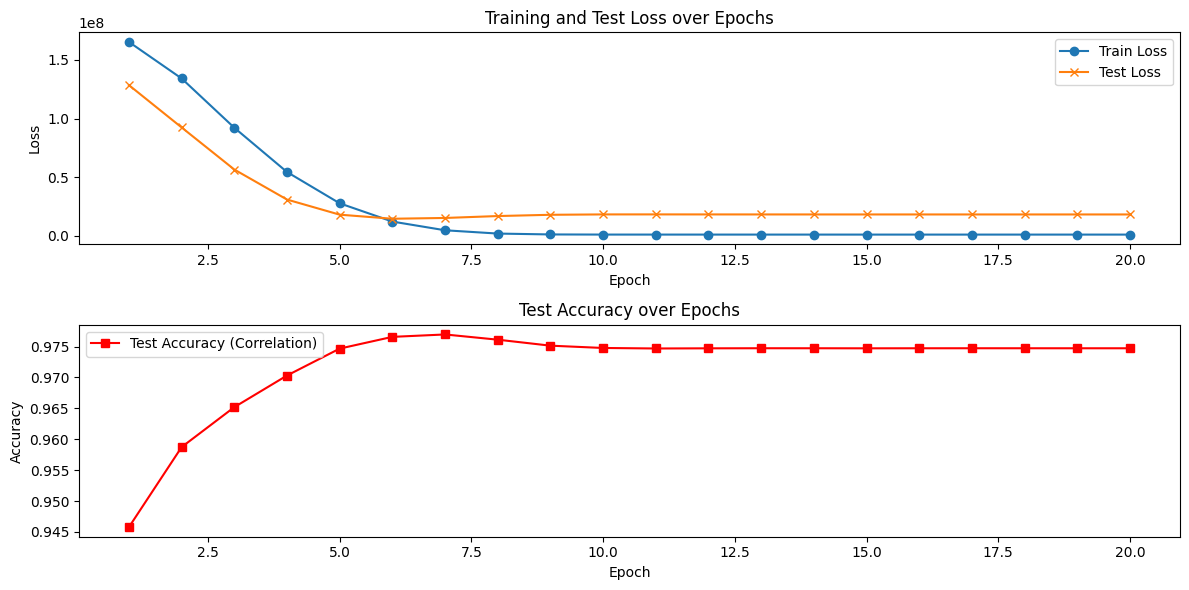

In [11]:
xformer_Su, optim = transformer_model.get_transformer(
    input_size=EPOCH_LEN,
    num_layers=num_layers,
    num_heads=num_heads,
    n_embd=EPOCH_LEN,
    out_dim=EEG_ELECTRODES,
    trial_len=ECoG_ELECTRODES,
    cuda=CUDA,
    weight_decay=0.001,
    learning_rate=0.001
)

# Continue training the best model and evaluate on the test set
test_losses = []
train_losses = []
test_accuracies = []
criterion = torch.nn.MSELoss()
num_epochs = 20

for epoch in range(num_epochs):
    # Training loop
    xformer_Su.train()
    total_train_loss = 0.0
    for data, targets in train_loader_Su:
        data, targets = data.to(CUDA), targets.to(CUDA)
        optim.zero_grad()
        outputs = xformer_Su(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optim.step()
        total_train_loss += loss.item() * data.size(0)

    avg_train_loss = total_train_loss / len(train_loader_Su.dataset)
    train_losses.append(avg_train_loss)

    # Evaluation on the test set
    xformer_Su.eval()
    total_test_loss = 0.0
    all_outputs = []
    all_targets = []
    with torch.no_grad():
        for data, targets in test_loader_Su:
            data, targets = data.to(CUDA), targets.to(CUDA)
            outputs = xformer_Su(data)
            loss = criterion(outputs, targets)
            total_test_loss += loss.item() * data.size(0)
            all_outputs.append(outputs)
            all_targets.append(targets)

    avg_test_loss = total_test_loss / len(test_loader_Su.dataset)
    test_losses.append(avg_test_loss)

    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Calculate accuracy using correlation coefficient
    correlation_matrix = torch.corrcoef(torch.stack([all_outputs.flatten(), all_targets.flatten()]))
    accuracy = (correlation_matrix[0, 1].item() + 1)/2
    test_accuracies.append(accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}, Accuracy: {accuracy}')

# Plot both training and test loss on the same figure
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, marker='x', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='s', color='r', label='Test Accuracy (Correlation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

torch.save(xformer_Su, '/content/drive/MyDrive/Colab Notebooks/one_object/best_model_20epoch_su.pth')

# Predict
You can skip the training step, and load the weights we saved directly to use the modle.
* output/transformer_trained/best_model_20epoch_su.pth

In [ ]:
# Load the saved model
loaded_model = torch.load('/content/drive/MyDrive/Colab Notebooks/one_object/best_model_20epoch_su.pth')
loaded_model.eval()  # Set the model to evaluation mode

# Move the model to CUDA if available
if CUDA:
    loaded_model = loaded_model.to(CUDA)

# Initialize lists to store outputs and targets
val_outputs = []

# Evaluate the model on the validation set
with torch.no_grad():
    for data, targets in val_loader_Su:
        data = data.to(CUDA)
        outputs = loaded_model(data)
        outputs = val_dataset.denormalize_targets(outputs)
        val_outputs.append(outputs)

# Concatenate all outputs
val_outputs = torch.cat(val_outputs, dim=0)

print(f'Prediction completed.')